In [29]:
import re
import os
import sys
import json
import langchain
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import START, StateGraph, MessagesState
from langchain_core.messages import SystemMessage, HumanMessage
from schemas.mondial_federated_schema import MONDIAL_ECONOMY, MONDIAL_GEO, MONDIAL_POlITICS, MONDIAL_SOCIAL, MONDIAL_FULL_SCHEMA

load_dotenv()

True

In [2]:
SameAsTable_path = "schemas/consolidated_sameastable.json"

with open(SameAsTable_path) as f:
    SameAsTable = json.load(f)
    
SameAsTable

[{'Endpoint Source': 'MONDIAL_ECONOMY',
  'Class Source': 'Economy',
  'Properties Source': 'country',
  'Endpoint Destination': 'MONDIAL_SOCIAL',
  'Class Destination': 'Religion',
  'Properties Destination': 'Country'},
 {'Endpoint Source': 'MONDIAL_ECONOMY',
  'Class Source': 'Economy',
  'Properties Source': 'country',
  'Endpoint Destination': 'MONDIAL_SOCIAL',
  'Class Destination': 'EthnicGroup',
  'Properties Destination': 'Country'},
 {'Endpoint Source': 'MONDIAL_ECONOMY',
  'Class Source': 'Economy',
  'Properties Source': 'country',
  'Endpoint Destination': 'MONDIAL_SOCIAL',
  'Class Destination': 'Language',
  'Properties Destination': 'Country'},
 {'Endpoint Source': 'MONDIAL_ECONOMY',
  'Class Source': 'Economy',
  'Properties Source': 'country',
  'Endpoint Destination': 'MONDIAL_SOCIAL',
  'Class Destination': 'Countrylocalname',
  'Properties Destination': 'Country'},
 {'Endpoint Source': 'MONDIAL_ECONOMY',
  'Class Source': 'Economy',
  'Properties Source': 'country'

In [55]:
def retrieve_relevant_sameastable_relations(relevant_tables: list) -> str:
    """
    Retrieve relevant same-as-table relations based on the provided list of relevant tables.
    Args:
        relevant_tables (list): A list of relevant table names.
    """
    
    SameAsTable_path = "schemas/consolidated_sameastable.json"
    
    with open(SameAsTable_path) as f:
        same_as_table_json = json.load(f)
        
    relevant_relations = []
    
    for relation in same_as_table_json:
        is_relevant = (
                (relation['Class Source'] in relevant_tables) 
                or 
                (relation['Class Destination'] in relevant_tables)
        )
        
        if is_relevant:
            relevant_relations.append(relation)
    
    final_relations = "" 
    for relation in relevant_relations:
        relation = json.dumps(relation)
        final_relations += relation + "\n"
        
    return final_relations

final_relations = retrieve_relevant_sameastable_relations(['Economy', 'Politics'])

for relation in relevant_relations:
    print(relation)

{'Endpoint Source': 'MONDIAL_ECONOMY', 'Class Source': 'Economy', 'Properties Source': 'country', 'Endpoint Destination': 'MONDIAL_SOCIAL', 'Class Destination': 'Religion', 'Properties Destination': 'Country'}
{'Endpoint Source': 'MONDIAL_ECONOMY', 'Class Source': 'Economy', 'Properties Source': 'country', 'Endpoint Destination': 'MONDIAL_SOCIAL', 'Class Destination': 'EthnicGroup', 'Properties Destination': 'Country'}
{'Endpoint Source': 'MONDIAL_ECONOMY', 'Class Source': 'Economy', 'Properties Source': 'country', 'Endpoint Destination': 'MONDIAL_SOCIAL', 'Class Destination': 'Language', 'Properties Destination': 'Country'}
{'Endpoint Source': 'MONDIAL_ECONOMY', 'Class Source': 'Economy', 'Properties Source': 'country', 'Endpoint Destination': 'MONDIAL_SOCIAL', 'Class Destination': 'Countrylocalname', 'Properties Destination': 'Country'}
{'Endpoint Source': 'MONDIAL_ECONOMY', 'Class Source': 'Economy', 'Properties Source': 'country', 'Endpoint Destination': 'MONDIAL_SOCIAL', 'Class De

In [56]:
llm = ChatOpenAI(temperature=0, model="gpt-4o")

def get_relevant_tables(question: str) -> list:
    """
    Retrieve the relevant tables based on the user's question.
    Args:
        question (str): The user's question.
    """
    
    prompt = """
    You are an assistant especialized in extracting relevant tables from a question.
    Your task is to determine which tables in the database are relevant to the user's question.
    
    The database schema is provided below:
    {schema}
    
    The user's question is: {question}
    
    YOU ONLY CAN ANSWER 2 TYPES OF ANSWERS:
    1- A list of tables that are relevant to the user's question.
    2- A question about the user's question, to solve any ambiguities. It always need to be the type of answers if in user question have any entity that isn't in the schema explicity.
    
    YOUR ANSWER IS 1. MUST BE A LIST OF TABLES, SEPARATED BY COMMAS.
    """
    
    chain = llm | StrOutputParser()
    
    relevant_tables = chain.invoke(prompt.format(schema=MONDIAL_FULL_SCHEMA, question=question))
    
    # convert relevant tables in a list of strings
    relevant_tables = relevant_tables.split(", ")
    return relevant_tables

print(get_relevant_tables("What is the GDP and religions of Brazil?"))

['Economy', 'Religion']


In [57]:
subquery_prompt = """
You are an intelligent assistant specialized in federated databases. Your task is to analyze a query and determine how it can be split into subqueries for different federated databases. 

Here is the schema of the federated database:
1. MONDIAL_ECONOMY:
{economy_schema}
2. MONDIAL_SOCIAL:
{social_schema}
3. MONDIAL_GEO:
{geo_schema}
4. MONDIAL_POLITICS:
{politics_schema}

Here are the relationships between tables across schemas:
1. SameAsTable relationships:
{same_as_table}

### Query
"{query}"

### Task
1. Identify the tables and columns relevant to this query.
2. Indicate which federated schema each table belongs to.
3. Suggest SQL subqueries for each schema to retrieve the required data.
4. Specify conditions that can be applied within each subquery.

Answer ALL AND ONLY IN JSON format with the following structure:
{{
  "subqueries": [
    {{
      "schema": "Schema Name",
      "tables": ["Table1", "Table2"],
      "columns": ["Column1", "Column2"],
      "conditions": ["Condition1", "Condition2"],
      "sql": "Generated SQL"
    }}
  ]
}}
"""

integration_prompt = """
You are an intelligent assistant responsible for integrating results from multiple federated databases.

Here are the SQL subqueries already generated:
{subqueries}

Here are the relationships between tables:
1. SameAsTable relationships:
{same_as_table}
2. ExternalObjectProperty relationships:
{external_object_property}

Task:
1. Identify how the results of these subqueries should be combined (JOIN or UNION).
2. Specify the columns used for integration (e.g., common keys).
3. Generate the final SQL query to integrate all subqueries.

Answer ALL AND ONLY IN JSON format:
{{
  "integration_plan": {{
    "method": "JOIN/UNION",
    "columns": ["Column1", "Column2"],
    "sql": "Generated SQL"
  }}
}}
"""

In [63]:
from schemas.mondial_federated_schema import MONDIAL_ECONOMY, MONDIAL_GEO, MONDIAL_POlITICS, MONDIAL_SOCIAL, MONDIAL_FULL_SCHEMA

def get_subqueries(query: str, relationships: str) -> str:
    """
    Generate subqueries for each federated schema based on the user's query.
    Args:
        query (str): The user's query.
        relationships (str): The SameAsTabgle relationships between tables across schemas.
    """
    
    prompt = subquery_prompt.format(
        economy_schema=MONDIAL_ECONOMY,
        social_schema=MONDIAL_SOCIAL,
        geo_schema=MONDIAL_GEO,
        politics_schema=MONDIAL_POlITICS,
        same_as_table=relationships,
        query=query
    )
    
    human_msg = HumanMessage(
        content=prompt
    )
    
    chain = llm | StrOutputParser()
    result = chain.invoke([human_msg])
    
    return result

query = "Retrieve the GDP and religion of countries in South America."

relevant_tables = get_relevant_tables(query)

relations = retrieve_relevant_sameastable_relations(relevant_tables)

subqueries = get_subqueries(query, relations)

print(subqueries)

```json
{
  "subqueries": [
    {
      "schema": "MONDIAL_ECONOMY",
      "tables": ["Economy"],
      "columns": ["Country", "GDP"],
      "conditions": ["Country IN (SELECT Country FROM encompasses WHERE Continent = 'South America')"],
      "sql": "SELECT Country, GDP FROM Economy WHERE Country IN (SELECT Country FROM encompasses WHERE Continent = 'South America')"
    },
    {
      "schema": "MONDIAL_SOCIAL",
      "tables": ["Religion"],
      "columns": ["Country", "Name", "Percentage"],
      "conditions": ["Country IN (SELECT Country FROM encompasses WHERE Continent = 'South America')"],
      "sql": "SELECT Country, Name, Percentage FROM Religion WHERE Country IN (SELECT Country FROM encompasses WHERE Continent = 'South America')"
    }
  ]
}
```


In [64]:
tools = [get_relevant_tables, retrieve_relevant_sameastable_relations, get_subqueries]

llm_with_tools = llm.bind_tools(tools)

assistant_prompt = """
# You are a chatbot agent that responds to user questions about a database.

# Rules:
First, verify if the question is related to the database. If it is not, act as a normal chatbot and answer the question and don't call any tool.

If it is, determine whether the question needs to be rewritten.
If so, enrich the question with relevant data from the conversation history. Otherwise, use the original question for the next step.

You can use 2 types of tools:
1- get_relevant_tables: This tool is used to determine which tables in the database are relevant to the user's question.
2- retrieve_relevant_sameastable_relations: This tool is used to retrieve the same-as-table relations for the relevant tables.

!! Always use the tools in order: get_relevant_tables, retrieve_relevant_sameastable_relations, get_subqueries !! 

# Attention:
Do not attempt to convert the user’s question to SQL; this is the tool's responsibility.

# The database schema is provided below. If the user asks a question outside the schema’s scope, apologize and inform them that it is beyond your scope.
{schema}

# User's question: {input}
"""

prompt_with_schema = assistant_prompt.replace("{schema}", MONDIAL_FULL_SCHEMA)

def assistant(state: MessagesState):
    sys_msg = SystemMessage(
        content=prompt_with_schema.format(input=state["messages"][-1].content)
    )

    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
graph = builder.compile()

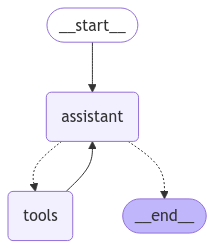

In [65]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [66]:
messages = [HumanMessage(content="Retrieve the GDP and religion of countries in South America?")]
result = graph.invoke({"messages": messages})

In [67]:
result

{'messages': [HumanMessage(content='Retrieve the GDP and religion of countries in South America?', additional_kwargs={}, response_metadata={}, id='a7eb4452-c290-485b-9095-dd6cbab948fe'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VrPhXz16NXCJnnj5gmhjYbzw', 'function': {'arguments': '{"question":"Retrieve the GDP and religion of countries in South America?"}', 'name': 'get_relevant_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 3085, 'total_tokens': 3112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b080c733-d3e1-4ced-a129-54c49bdd9e30-0', tool_calls=[{'name': 'get_relevant_tables', 'args': {'

In [68]:
for message in result["messages"]:
    print(message.content)
    print("-"*50)

Retrieve the GDP and religion of countries in South America?
--------------------------------------------------

--------------------------------------------------
["Economy", "Religion", "encompasses"]
--------------------------------------------------

--------------------------------------------------
{"Endpoint Source": "MONDIAL_ECONOMY", "Class Source": "Economy", "Properties Source": "country", "Endpoint Destination": "MONDIAL_SOCIAL", "Class Destination": "Religion", "Properties Destination": "Country"}
{"Endpoint Source": "MONDIAL_ECONOMY", "Class Source": "Economy", "Properties Source": "country", "Endpoint Destination": "MONDIAL_SOCIAL", "Class Destination": "EthnicGroup", "Properties Destination": "Country"}
{"Endpoint Source": "MONDIAL_ECONOMY", "Class Source": "Economy", "Properties Source": "country", "Endpoint Destination": "MONDIAL_SOCIAL", "Class Destination": "Language", "Properties Destination": "Country"}
{"Endpoint Source": "MONDIAL_ECONOMY", "Class Source": "Econo